# Taller 2
## Daniel Leyva Castro

In [23]:
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import numpy as np
from copy import deepcopy
import networkx as nx

## Funciones y clases Auxiliares

In [24]:
# helper functions
def crossProduct(p0, p1, p2):
    x0, y0 = p0
    x1, y1 = p1
    x2, y2 = p2
    return (x1-x0)*(y2-y0) - (x2-x0)*(y1-y0)


def rotation(p0, p1, p2):
    cp = crossProduct(p0, p1, p2)
    if cp > 0:
        return 'l' # left
    elif cp == 0:
        return None # collinear
    else:
        return 'r' # right

class Node:
    def __init__(self, data):
        self.data = data
        self.left = None
        self.right = None


def insertBST(root, node, y):

    if node.data.sp_intersection_point(y) < root.data.sp_intersection_point(y):
        if root.left is None:
            root.left = node
        else:
            insertBST(root.left, node, y)
    else:
        if root.right is None:
            root.right = node
        else:
            insertBST(root.right, node, y)


def inOrder(node):
    inorderArr = []

    if node.left is not None:
        leftInorderArr = inOrder(node.left)
        inorderArr.extend(leftInorderArr)

    inorderArr.append(node.data)

    if node.right is not None:
        rightInorderArr = inOrder(node.right)
        inorderArr.extend(rightInorderArr)
    return inorderArr


## Vertices, Arista, Semiaristas y Caras


In [25]:
# vertex plot utilities
types = {
    'unknown': ('o', "unknown"),
    'o': ('sg', 'Origin'),
    'e': ('sr', 'End'),
    's': ('^k', 'Split'),
    'm': ('vy', 'Merge'),
    'r': ('ob', 'Regular'),
#    'h': '*m'
}

class Vertex:
    def __init__(self, label = None, x=None, y=None, incident = []):
        self.label = label
        self.x = x
        self.y = y
        self.coords = (x,y)
        self.incident = incident
        self.vtype = 'unknown'
        self.color = None

    def toTuple(self):
        return self.coords

    def __lt__(self, p):
        return (self.y > p.y) or (self.y == p.y and self.x < p.x)

    def __repr__(self):
        return f"V(L:{self.label} C:({self.x},{self.y}) I:{[i.label for i in self.incident]})"
        # return f"V({self.coords} - {self.color})"

    def __str__(self):
        return f"V(L:{self.label} C:({self.x},{self.y}) I:{[i.label for i in self.incident]})"
        # return f"V({self.coords} - {self.color})"
    def add2plot(self):
        plt.plot(self.x, self.y, types[self.vtype][0], label=types[self.vtype][1])


class Edge:
    def __init__(self, start, end):
        self.start = start
        self.end = end

    def __repr__(self):
        return f"E({self.start.coords} -> {self.end.coords})"

    def __srt__(self):
        return f"E({self.start.coords} -> {self.end.coords})"

    def add2plot(self):
        #with no label
        plt.plot([self.start.x, self.end.x], [self.start.y, self.end.y], '-k', label='_nolegend_')

class SemiEdge:
    def __init__(self, label=None, start=None, prev=None, next=None, twin=None, face=None):
        self.label = label
        self.start = start
        self.prev = prev
        self.next = next
        self.twin = twin
        self.face = face
        self.helper = None

    def sp_intersection_point(self, y):
        alpha = (y - self.next.start.y) / (self.start.y - self.next.start.y)
        x = alpha * self.start.x + (1 - alpha) * self.next.start.x
        return x

    def add2plot(self):
        plt.plot([self.start.x, self.next.start.x], [self.start.y, self.next.start.y], '-k')

    def __repr__(self):
        return f'{self.label}({self.start.coords}, {self.next.start.coords})' if self.next else f'{self.label}({self.start.coords})'

    def __str__(self):
        return f'{self.label}({self.start.coords}, {self.next.start.coords})' if self.next else f'{self.label}({self.start.coords})'



class Face:
    def __init__(self, extF=None, intF=None, label=None):
        if intF is None:
            intF = []
        if extF is None:
            extF = []
        self.extF = extF
        self.intF = intF
        self.label = label

    def __repr__(self):
        return f"\n------------\nF(L:{self.label}\nextF:{self.extF}\nintF:{self.intF}\n------------\n)"

    def add2plot(self, color=''):
        #plot filled face
        plt.fill([i.start.x for i in self.extF], [i.start.y for i in self.extF],color, alpha=0.2)



## Clase Principal

In [26]:
# Main class
class LDCE:
    def __init__(self, points):
        # LDCE attributes
        self.vertices = []
        self.semiEdges = None
        self.faces = []

        self.points = points
        self.edges = None
        self.build()
        self.assingNodesTypes()

        # Y Monotone Atributes
        self.Q = []
        self.T = None
        self.TArr = []

        # Graph Atributes
        self.graph = None
        self.colored = []
        self.vertices_colors = []

    def plotPolygon(self):
        self.plotSemiEdges()
        self.plotVertices()

    def plotEdges(self):
        for e in self.edges:
            e.add2plot()

    def plotSemiEdges(self):
        for e in self.semiEdges:
            e.add2plot()

    def plotVertices(self, showTypes=True):
        points = {}
        for p in self.vertices:
            if types[p.vtype] not in points:
                points[types[p.vtype]] = [p.coords]
            else:
                points[types[p.vtype]].append(p.coords)
        # pprint.pprint(points)
        for i in points:
            plt.plot(*zip(*points[i]), i[0] if showTypes else 'bo', label=i[1])

    def plotFaces(self, color=''):
        for f in self.faces:
            f.add2plot(color=color)

    def vertices2Df(self):
        vtypes = [types[i.vtype][1] for i in self.vertices]
        coords = [i.coords for i in self.vertices]
        labels = [i.label for i in self.vertices]
        incident = [i.incident for i in self.vertices]
        colors = [i.color for i in self.vertices]

        df = {
            'Vertex': labels,
            'Type': vtypes,
            'Coords': coords,
            'Incident': incident,
            'Color': colors
        }
        return pd.DataFrame(data = df)

    def semiEdges2Df(self):
        labels = [se.label for se in self.semiEdges]
        starts = [se.start.label for se in self.semiEdges]
        end_points = [se.next.start.label for se in self.semiEdges]
        prevs = [se.prev.label for se in self.semiEdges]
        nexts = [se.next.label for se in self.semiEdges]
        twins = [se.twin.label for se in self.semiEdges]
        faces = [se.face.label if se.face is not None else None for se in self.semiEdges]

        df = {'SemiEdge': labels, 'Start Points': starts, 'End Points': end_points, 'Prev': prevs, 'Nexts': nexts,
             'Twin': twins, 'Face': faces}
        #d = {'SemiEdge': labels, 'Start Points': starts, 'End Points': end_points, 'Prev': prevs, 'Nexts': nexts, 'Twin': twins}
        return pd.DataFrame(data = df)


    def faces2Df(self):
        inF = [[s.label for s in f.intF] if f.intF else None for f in self.faces]
        exF = [[s.label for s in f.extF] if f.extF else None for f in self.faces]
        labels = [f.label for f in self.faces]
        df = {
            'Face': labels,
            'Internal': inF,
            'External': exF
        }
        return pd.DataFrame(data = df)

    def build(self):
        # Create the List of Doubly Connected Edges
        self.semiEdges = [[],[]]
        self.vertices = [Vertex(f'{self.points.index(i)}', *i) for i in self.points]
        edges = [Edge(self.vertices[i], self.vertices[(i+1)%len(self.vertices)]) for i in range(len(self.vertices))]

        for i in range(len(edges)):
            ns = SemiEdge(start=edges[i].start, label=f'S{i},1')
            nt = SemiEdge(start=edges[i].end, label=f'S{i},2')
            ns.twin = nt
            nt.twin = ns
            self.semiEdges[0].append(ns)
            self.semiEdges[1].append(nt)
        self.semiEdges[1].reverse()

        for i in range(len(self.semiEdges[0])-1):
            self.semiEdges[0][i].next = self.semiEdges[0][(i+1)]
            self.semiEdges[0][i].prev = self.semiEdges[0][(i-1)]
            self.semiEdges[1][i].next = self.semiEdges[1][(i+1)]
            self.semiEdges[1][i].prev = self.semiEdges[1][(i-1)]

        self.semiEdges[0][-1].next = self.semiEdges[0][0]
        self.semiEdges[0][-1].prev = self.semiEdges[0][-2]
        self.semiEdges[1][-1].next = self.semiEdges[1][0]
        self.semiEdges[1][-1].prev = self.semiEdges[1][-2]

        for i in range(len(self.vertices)):
            self.vertices[i].incident = [self.semiEdges[0][i], self.semiEdges[0][i].twin.next]

        next = self.semiEdges[0][1]
        v0 = self.semiEdges[0][0].start
        count = 0
        front1 = [self.semiEdges[0][0]]

        while next.start != v0:
            if count > len(self.semiEdges[0]):
                print('Error')
                break
            count += 1
            front1.append(next)
            next = next.next

        next = self.semiEdges[1][1]
        v0 = self.semiEdges[1][0].start
        count = 0
        front2 = [self.semiEdges[1][0]]

        while next.start != v0:
            if count > len(self.semiEdges[1]):
                print('Error')
                break
            count += 1
            front2.append(next)
            next = next.next

        f1 = Face(extF=None, intF=front1, label='F1')
        f2 = Face(extF=front2, intF=None, label='F2')

        for se in f1.intF:
            se.face = f1

        for se in f2.extF:
            se.face = f2

        self.faces.append(f1)
        self.faces.append(f2)
        self.semiEdges = self.semiEdges[0] + self.semiEdges[1]
        self.edges = edges

    def assingNodesTypes(self):
        # Assigning the type of each vertex
        for se in self.faces[0].intF:
            prev_p = se.prev.start.coords
            curr_p = se.start.coords
            next_p = se.next.start.coords

            if (se.start.y >= se.prev.start.y and se.start.y > se.next.start.y) or (se.start.y > se.prev.start.y and se.start.y >= se.next.start.y):
                if rotation(prev_p, curr_p, next_p) == 'l':
                    se.start.vtype = 's'
                else:
                    se.start.vtype = 'o'
            elif (se.start.y <= se.prev.start.y and se.start.y < se.next.start.y) or (se.start.y < se.prev.start.y and se.start.y <= se.next.start.y):
                if rotation(prev_p, curr_p, next_p) == 'l':
                    se.start.vtype = 'm'
                else:
                    se.start.vtype = 'e'

            else:
                se.start.vtype = 'r'

    #######################################################################
    ######################## YMonotone Functions ##########################
    #######################################################################

    def addDiagonal(self, v1, v2):
        ek1 = SemiEdge(start=v1)
        ek2 = SemiEdge(start=v2)
        ek1.twin = ek2
        ek2.twin = ek1

        v1.incident.append(ek1)
        v2.incident.append(ek2)

        for i in self.semiEdges:
            if i.start.coords == v1.coords and i.face.intF == []:
                ea = i
                eb = None
                for j in self.semiEdges:
                    if j != i:
                        if j.start.coords == v2.coords and j.face.intF == [] and i.face.label == j.face.label:
                            eb = j
                            break
                if eb is not None:
                    break

        ea.prev.next = ek1
        eb.prev.next = ek2
        ek1.prev = ea.prev
        ek2.prev = eb.prev
        ek1.next = eb
        ek2.next = ea
        ea.prev = ek2
        eb.prev = ek1

        self.faces.remove(ea.face)

        k = int(len(self.semiEdges)/2)
        ek1.label = f"S{k},1"
        ek2.label = f"S{k},2"

        next = ek1.next
        v0 = ek1.start

        front_1 = [ek1]

        while next.start.coords != v0.coords:
            front_1.append(next)
            next = next.next

        next = ek2.next
        v0 = ek2.start

        front_2 = [ek2]

        while next.start.coords != v0.coords:
            front_2.append(next)
            next = next.next

        self.semiEdges.append(ek1)
        self.semiEdges.append(ek2)

        k = np.random.randint(100, 2**9)

        Fa = Face(extF=front_1, intF=None, label=f"F{k}")
        Fb = Face(extF=front_2, intF=None, label=f"F{k+1}")

        for i in front_1:
            i.face = Fa

        for i in front_2:
            i.face = Fb

        self.faces.append(Fa)
        self.faces.append(Fb)

        for i in range(1, len(self.faces)):
            self.faces[i].label = f"F{i+1}"

    def delSemiEdge(self, se, y):
        self.TArr = inOrder(self.T)

        if se in self.TArr:
            self.TArr.remove(se)
            root = self.TArr.pop(0)
            self.T = Node(root)
            for i in self.TArr:
                insertBST(self.T, Node(i), y - 0.2)
            self.TArr = inOrder(self.T)
        else:
            raise Exception('SemiEdge not in T')

    def add2T(self, e, p):
        insertBST(self.T, Node(e), p.y - 0.2)
        self.TArr = inOrder(self.T)

    def getNearLeft(self, p):
        xs = [i.sp_intersection_point(p.y) for i in self.TArr]
        xs.append(float(p.x))
        xs.sort()
        index = xs.index(float(p.x))
        ej = self.TArr[index-1]
        return ej

    def findHelperEdge(self, p):
        # pprint.pprint(p.incident)
        for i in p.incident:
            if i.face.label == 'F1':
                ei = i
                break

        if ei is None:
            raise Exception('No helper edge found')
        return ei

    def getSide(self, p):
        ei = self.findHelperEdge(p)

        if ei.prev.start.y < ei.next.start.y:
            return 'r'
        else:
            return 'l'

    def makeMonotone(self):
        it = 0
        self.Q = deepcopy(self.vertices)
        self.Q.sort()
        e1 = self.findHelperEdge(self.Q[0])
        self.T = Node(e1)

        while len(self.Q) != 0:
            self.TArr = inOrder(self.T)
            p = self.Q.pop(0)
            self.vertexManipulation(p)
            it += 1

    def vertexManipulation(self, p):
        t = p.vtype
        if t == 's': self.manipulateSplit(p)
        elif t == 'e': self.manipulateEnd(p)
        elif t == 'm': self.manipulateMerge(p)
        elif t == 'o': self.manipulateOrigin(p)
        elif t == 'r': self.manipulateRegular(p)
        else: raise Exception('Error :(')

    def manipulateOrigin(self, p):
        ei = self.findHelperEdge(p).prev
        self.add2T(ei, p)
        ei.helper = p

    def manipulateEnd(self, p):
        ei_1 = self.findHelperEdge(p)
        if ei_1.helper.vtype == 'm':
            self.addDiagonal(p, ei_1.helper)
        self.delSemiEdge(ei_1, p.y)

    def manipulateMerge(self, p):
        ei_1 = self.findHelperEdge(p)
        if ei_1.helper.vtype == 'm':
            self.addDiagonal(p, ei_1.helper)
        self.delSemiEdge(ei_1, p.y)
        ej = self.getNearLeft(p)
        if ej.helper.vtype == 'm':
            self.addDiagonal(p, ej.helper)
        ej.helper = p


    def manipulateSplit(self, p):
        ej = self.getNearLeft(p)
        self.addDiagonal(p, ej.helper)
        ej.helper = p

        ei = self.findHelperEdge(p).prev
        ei.helper = p
        self.add2T(ei, p)

    def manipulateRegular(self, p):
        side = self.getSide(p)
        if side == 'r':
            ei_1 = self.findHelperEdge(p)
            if ei_1.helper.vtype == 'm':
                self.addDiagonal(p, ei_1.helper)
            self.delSemiEdge(ei_1, p.y)
            ei_1.prev.helper = p
            self.add2T(ei_1.prev, p)
        else:
            ej = self.getNearLeft(p)
            if ej.helper.vtype == 'm':
                self.addDiagonal(p, ej.helper)
            ej.helper = p

    #######################################################################
    ####################### Triangulation functions #######################
    #######################################################################
    def getSideT(self, p, face):
        for i in p.incident:
            if i.face.label == face.label:
                ei = i
                break

        if ei.prev.start.y > ei.next.start.y:
            return 'r'
        else:
            return 'l'

    def checkDiagonalOS(self, v1, v2, face):
        check = True
        for i in v1.incident:
            if (i.prev.start == v2 or i.next.start == v2) and (i.face == face):
                check = False
                break
        if check:
            self.addDiagonal(v1, v2)

    def checkDiagonalSS(self, v1, v2, v3, face):
        check = True
        for i in v1.incident:
            if (i.prev.start == v3 or i.next.start == v3) and (i.face == face):
                check = False
                break
        if check:
            if self.getSideT(v1, face) == 'r':
                if rotation(v1.coords, v2.coords, v3.coords) == 'r':
                    self.addDiagonal(v1, v3)
                    return True
            elif self.getSideT(v1, face) == 'l':
                if rotation(v1.coords, v2.coords, v3.coords) == 'l':
                    self.addDiagonal(v1, v3)
                    return True

        return False

    def triangulate(self):
        faces = deepcopy(self.faces)
        for i in faces:
            if i.label != 'F1':
                self.triangulateFace(i)

    def triangulateFace(self, face):
        SQ = [i.start for i in face.extF]
        SQ.sort()

        S = [SQ[0], SQ[1]]

        for i in range(2, len(SQ)-1):
            if self.getSideT(S[-1], face) != self.getSideT(SQ[i], face):
                while len(S) > 1:
                    s = S.pop()
                    self.checkDiagonalOS(SQ[i], s, face)
                S.append(SQ[i-1])
                S.append(SQ[i])
            else:
                s = S.pop()
                s_len = len(S)

                for j in range(s_len):
                    if len(S) == 1:
                        added = self.checkDiagonalSS(SQ[i], s, S[0], face)
                        if not added:
                            S.append(s)
                        break
                    s = S.pop()
                    added = self.checkDiagonalSS(SQ[i], S[j-1], s, face)
                    if not added:
                        S.append(s)
                        break
                S.append(SQ[i])

    #######################################################################
    ######################### Dual Graph Utilites #########################
    #######################################################################
    def getTriangleCenter(self, face):
        t = [i.start.coords for i in face.extF]
        x = (t[0][0] + t[1][0] + t[2][0])/3
        y = (t[0][1] + t[1][1] + t[2][1])/3
        return (x, y)

    def getDualGraph(self):
        nodes = [f.label for f in self.faces[1:]]
        edges = []
        self.edgesCords = []

        for face in self.faces[1:]:
            for i in face.extF:
                for j in self.faces[1:]:
                    if face != j and i.twin in j.extF:
                            if (j.label, face.label) not in edges:
                                edges.append((face.label, j.label))
                                self.edgesCords.append((self.getTriangleCenter(face), self.getTriangleCenter(j)))

        graph = nx.Graph()
        graph.add_nodes_from(nodes)
        graph.add_edges_from(edges)

        self.graph = graph

    def colorFace(self, node):
        color = ['r', 'g', 'b']
        for i in self.faces[1:]:
            if i.label == node:
                face = i
                break

        areNone = []
        notNone = []
        for i in face.extF:
            if i.start.coords in [j.coords for j in self.vertices_colors]:
                i.start.color = [j.color for j in self.vertices_colors if j.coords == i.start.coords][0]
            if i.start.color is not None:
                notNone.append(i.start)
            else:
                areNone.append(i.start)

        if len(areNone) == 3:
            for i in range(3):
                areNone[i].color = color[i]
                for v in self.vertices:
                    if v.coords == areNone[i].coords:
                        v.color = color[i]
                        self.vertices_colors.append(v)

        elif len(areNone) == 1:
            scolor = [k for k in color if k not in [j.color for j in notNone]][0]
            areNone[0].color = scolor
            for v in self.vertices:
                if v.coords == areNone[0].coords:
                    v.color = scolor
                    self.vertices_colors.append(v)
        else:
            print("Error :(")

    def threeColor(self, node):

        self.colored.append(node)
        self.colorFace(node)
        neighbors = self.graph.neighbors(node)
        for n in neighbors:
            if n not in self.colored:
                self.threeColor(n)

    def artGalleryProblem(self):
        node = list(self.graph.nodes)[0]
        self.threeColor(node)

        df = self.vertices2Df()
        color = df['Color'].value_counts().idxmin()
        cameras = [i for i in self.vertices if i.color == color]

        return cameras







## Creación del objeto

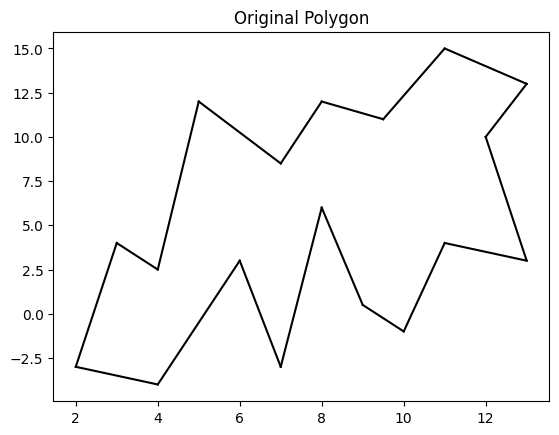

In [27]:
N = [(9, 0.5), (8, 6), (7, -3), (6, 3), (4, -4), (2, -3), (3, 4), (4, 2.5), (5, 12), (7, 8.5), (8, 12), (9.5, 11),
     (11, 15), (13, 13), (12, 10), (13, 3), (11, 4), (10, -1)]

ldce = LDCE(N)
plt.title("Original Polygon")
ldce.plotEdges()

## Punto 1 Lista de aristas doblemente enlazadas

La funcion `Build()` se encarga de crear la lista de aristas doblemente enlazadas, para esto se crean los vertices, aristas y semi aristas, luego se enlazan las semi aristas para formar la lista doblemente enlazada, luego se enlazan las semi aristas con los vertices para formar la lista de aristas incidentes en cada vertice, y por ultimo se crean las caras y se enlazan las semi aristas con las caras para formar la lista de semi aristas incidentes en cada cara.
### Vertices

In [28]:
df = ldce.vertices2Df()
display(df)

,Vertex,Type,Coords,Incident,Color
0,0,Regular,"(9, 0.5)","[S0,1((9, 0.5), (8, 6)), S17,2((9, 0.5), (10, ...",None
1,1,Split,"(8, 6)","[S1,1((8, 6), (7, -3)), S0,2((8, 6), (9, 0.5))]",None
2,2,End,"(7, -3)","[S2,1((7, -3), (6, 3)), S1,2((7, -3), (8, 6))]",None
3,3,Split,"(6, 3)","[S3,1((6, 3), (4, -4)), S2,2((6, 3), (7, -3))]",None
4,4,End,"(4, -4)","[S4,1((4, -4), (2, -3)), S3,2((4, -4), (6, 3))]",None
5,5,Regular,"(2, -3)","[S5,1((2, -3), (3, 4)), S4,2((2, -3), (4, -4))]",None
6,6,Origin,"(3, 4)","[S6,1((3, 4), (4, 2.5)), S5,2((3, 4), (2, -3))]",None
7,7,Merge,"(4, 2.5)","[S7,1((4, 2.5), (5, 12)), S6,2((4, 2.5), (3, 4))]",None
8,8,Origin,"(5, 12)","[S8,1((5, 12), (7, 8.5)), S7,2((5, 12), (4, 2....",None
9,9,Merge,"(7, 8.5)","[S9,1((7, 8.5), (8, 12)), S8,2((7, 8.5), (5, 1...",None


### SemiEdges

In [29]:
df = ldce.semiEdges2Df()
display(df)

,SemiEdge,Start Points,End Points,Prev,Nexts,Twin,Face
0,"S0,1",0,1,"S17,1","S1,1","S0,2",F1
1,"S1,1",1,2,"S0,1","S2,1","S1,2",F1
2,"S2,1",2,3,"S1,1","S3,1","S2,2",F1
3,"S3,1",3,4,"S2,1","S4,1","S3,2",F1
4,"S4,1",4,5,"S3,1","S5,1","S4,2",F1
5,"S5,1",5,6,"S4,1","S6,1","S5,2",F1
6,"S6,1",6,7,"S5,1","S7,1","S6,2",F1
7,"S7,1",7,8,"S6,1","S8,1","S7,2",F1
8,"S8,1",8,9,"S7,1","S9,1","S8,2",F1
9,"S9,1",9,10,"S8,1","S10,1","S9,2",F1


### Faces

In [30]:
df = ldce.faces2Df()
display(df)

,Face,Internal,External
0,F1,"[S0,1, S1,1, S2,1, S3,1, S4,1, S5,1, S6,1, S7,...",None
1,F2,None,"[S17,2, S16,2, S15,2, S14,2, S13,2, S12,2, S11..."


## Punto 2 Convertir en Ymonotono
### Identificar tipo de vertice.
La funcion `assingNodesTypes()` se encarga de asignar los tipos de nodos a cada vertice, para esto se recorre la lista de semi aristas incidentes en la cara 1, se obtienen los puntos previos, actuales y siguientes, luego se calcula la rotacion de los puntos, y se asigna el tipo de nodo segun la rotacion y la posicion del punto actual y sus vecinos.

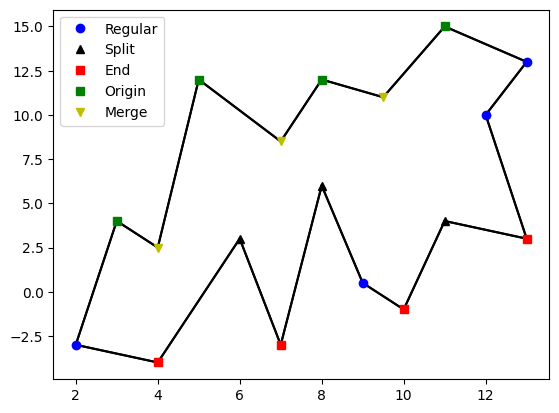

In [31]:
ldce.plotPolygon()
plt.legend()
plt.show()


La funcion `makeMonotone` modifica la lista de LDCE añadiendo las diagonales correspondientes, creando asi nuevas semi aristas y caras.

In [32]:
ldce.makeMonotone()

Text(0.5, 1.0, 'Y-Monotone Polygon')

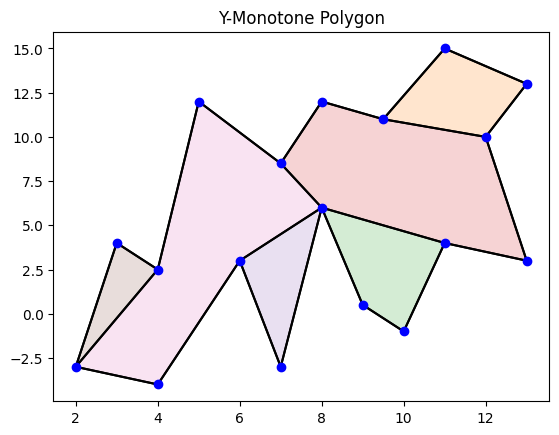

In [33]:
ldce.plotFaces()
ldce.plotSemiEdges()
ldce.plotVertices(showTypes=0)
plt.title("Y-Monotone Polygon")


### Lista de aristas doblemente enlazadas Y-monotono

In [34]:
df = ldce.semiEdges2Df()
display(df)

,SemiEdge,Start Points,End Points,Prev,Nexts,Twin,Face
0,"S0,1",0,1,"S17,1","S1,1","S0,2",F1
1,"S1,1",1,2,"S0,1","S2,1","S1,2",F1
2,"S2,1",2,3,"S1,1","S3,1","S2,2",F1
3,"S3,1",3,4,"S2,1","S4,1","S3,2",F1
4,"S4,1",4,5,"S3,1","S5,1","S4,2",F1
5,"S5,1",5,6,"S4,1","S6,1","S5,2",F1
6,"S6,1",6,7,"S5,1","S7,1","S6,2",F1
7,"S7,1",7,8,"S6,1","S8,1","S7,2",F1
8,"S8,1",8,9,"S7,1","S9,1","S8,2",F1
9,"S9,1",9,10,"S8,1","S10,1","S9,2",F1


In [35]:
df = ldce.faces2Df()
display(df)

,Face,Internal,External
0,F1,"[S0,1, S1,1, S2,1, S3,1, S4,1, S5,1, S6,1, S7,...",None
1,F2,None,"[S18,2, S13,2, S12,2, S11,2]"
2,F3,None,"[S20,1, S0,2, S17,2, S16,2]"
3,F4,None,"[S20,2, S15,2, S14,2, S18,1, S10,2, S9,2, S19,2]"
4,F5,None,"[S21,2, S2,2, S1,2]"
5,F6,None,"[S22,1, S6,2, S5,2]"
6,F7,None,"[S22,2, S4,2, S3,2, S21,1, S19,1, S8,2, S7,2]"


## Punto 3 Triangulación
La funcion `triangulate()` se encarga de triangular el poligono, para esto se recorren las caras (excepto F1), y se llama a la funcion `triangulateFace()` para triangular cada cara.

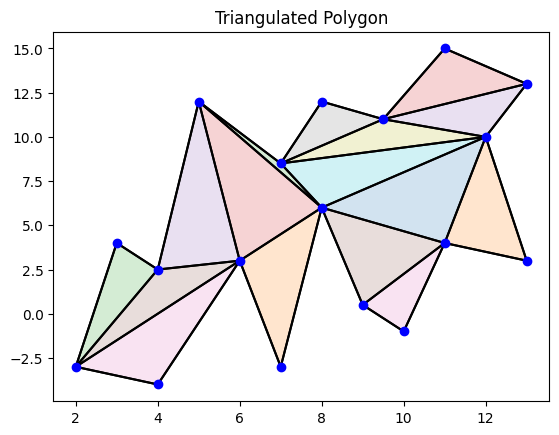

In [36]:
ldce.triangulate()
plt.title("Triangulated Polygon")
ldce.plotFaces()
ldce.plotSemiEdges()
ldce.plotVertices(showTypes=0)

### Lista de aristas doblemente enlazadas Triangulado

In [37]:
df = ldce.semiEdges2Df()
display(df)

,SemiEdge,Start Points,End Points,Prev,Nexts,Twin,Face
0,"S0,1",0,1,"S17,1","S1,1","S0,2",F1
1,"S1,1",1,2,"S0,1","S2,1","S1,2",F1
2,"S2,1",2,3,"S1,1","S3,1","S2,2",F1
3,"S3,1",3,4,"S2,1","S4,1","S3,2",F1
4,"S4,1",4,5,"S3,1","S5,1","S4,2",F1
...,...,...,...,...,...,...,...
61,"S30,2",8,3,"S29,1","S21,1","S30,1",F14
62,"S31,1",7,3,"S7,2","S30,1","S31,2",F15
63,"S31,2",3,7,"S32,1","S22,2","S31,1",F16
64,"S32,1",5,3,"S22,2","S31,2","S32,2",F16


In [38]:
df = ldce.faces2Df()
display(df)

,Face,Internal,External
0,F1,"[S0,1, S1,1, S2,1, S3,1, S4,1, S5,1, S6,1, S7,...",None
1,F2,None,"[S21,2, S2,2, S1,2]"
2,F3,None,"[S22,1, S6,2, S5,2]"
3,F4,None,"[S23,1, S12,2, S11,2]"
4,F5,None,"[S23,2, S18,2, S13,2]"
5,F6,None,"[S24,1, S20,1, S0,2]"
6,F7,None,"[S24,2, S17,2, S16,2]"
7,F8,None,"[S26,1, S10,2, S9,2]"
8,F9,None,"[S26,2, S25,1, S18,1]"
9,F10,None,"[S27,1, S25,2, S19,2]"


## Punto 4 Problema de la galeria de arte
Finalmente se calcula el grafo dual con la funcion `getDualGraph()`, luego se llama a la funcion `artGalleryProblem()` para obtener las camaras que cubren el menor numero de vertices.

In [39]:
ldce.getDualGraph()
cameras = ldce.artGalleryProblem()

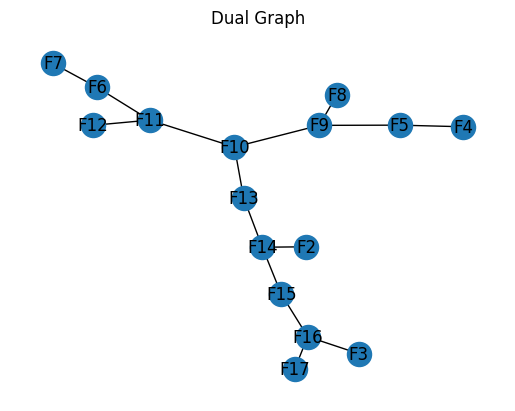

In [40]:
graph = ldce.graph
plt.title("Dual Graph")
nx.draw(graph, with_labels=True)

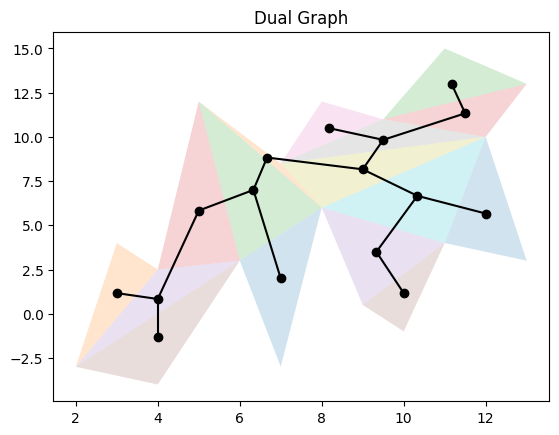

In [41]:
plt.title("Dual Graph")
for i in ldce.faces[1:]:
    i.add2plot()
    c = ldce.getTriangleCenter(i)
    plt.plot(c[0], c[1], 'o', color='k')

for i in ldce.edgesCords:
    plt.plot((i[0][0],i[1][0]), (i[0][1], i[1][1]), 'k-')


,Vertex,Type,Coords,Incident,Color
0,0,Regular,"(9, 0.5)","[S0,1((9, 0.5), (8, 6)), S17,2((9, 0.5), (10, ...",b
1,1,Split,"(8, 6)","[S1,1((8, 6), (7, -3)), S0,2((8, 6), (9, 0.5))]",r
2,2,End,"(7, -3)","[S2,1((7, -3), (6, 3)), S1,2((7, -3), (8, 6))]",b
3,3,Split,"(6, 3)","[S3,1((6, 3), (4, -4)), S2,2((6, 3), (7, -3))]",g
4,4,End,"(4, -4)","[S4,1((4, -4), (2, -3)), S3,2((4, -4), (6, 3))]",r
5,5,Regular,"(2, -3)","[S5,1((2, -3), (3, 4)), S4,2((2, -3), (4, -4))]",b
6,6,Origin,"(3, 4)","[S6,1((3, 4), (4, 2.5)), S5,2((3, 4), (2, -3))]",g
7,7,Merge,"(4, 2.5)","[S7,1((4, 2.5), (5, 12)), S6,2((4, 2.5), (3, 4))]",r
8,8,Origin,"(5, 12)","[S8,1((5, 12), (7, 8.5)), S7,2((5, 12), (4, 2....",b
9,9,Merge,"(7, 8.5)","[S9,1((7, 8.5), (8, 12)), S8,2((7, 8.5), (5, 1...",g


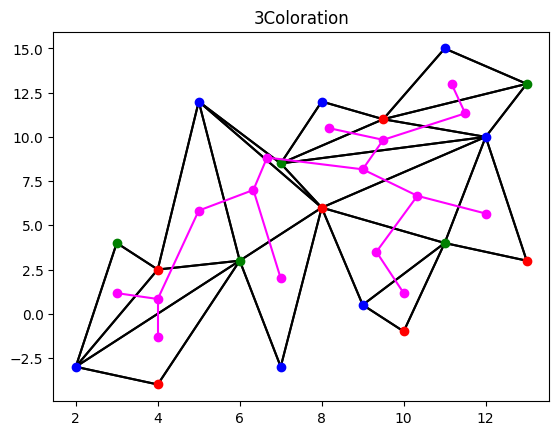

In [42]:
# print vertices data frame
df = ldce.vertices2Df()
display(df)
ldce.plotSemiEdges()
plt.title("3Coloration")

for i in ldce.vertices:
    plt.plot(i.x, i.y, 'o', color=i.color)

for i in ldce.faces[1:]:
    c = ldce.getTriangleCenter(i)
    plt.plot(c[0], c[1], 'o', color='fuchsia')
for i in ldce.edgesCords:
    plt.plot((i[0][0],i[1][0]), (i[0][1], i[1][1]), 'fuchsia')

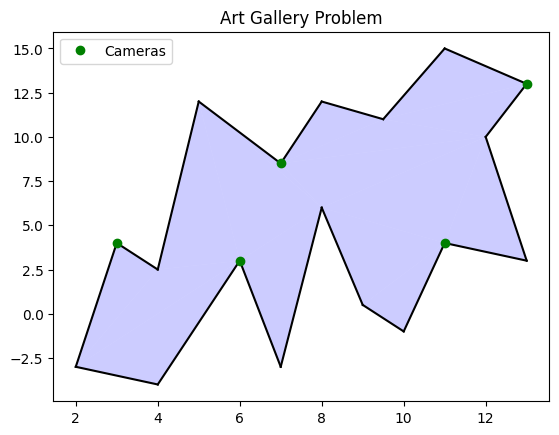

In [43]:
ldce.plotEdges()
ldce.plotFaces(color = 'b')
plt.title("Art Gallery Problem")
cameras_cords = []

for i in cameras:
    plt.plot(i.x, i.y, 'o', color=i.color, label="Cameras")
    cameras_cords.append(i.coords)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())


In [44]:
print(f"Se necesitan {len(cameras)} camaras para cubrir el menor numero de vertices")
print("Coordenadas de las camaras: ")
pprint.pprint(cameras_cords)

Se necesitan 5 camaras para cubrir el menor numero de vertices
Coordenadas de las camaras: 
[(6, 3), (3, 4), (7, 8.5), (13, 13), (11, 4)]
